In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.patches as patches


#parameters:

dt = .0000625
nx = 251
ny = 251
nt = 20
nit = 50
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)



In [4]:
class obstacle(object):
    def __init__(self, x1, y1, x2, y2):
        self.botLeft = [x1, y1]
        self.topRight = [x2, y2]
        self.width = np.abs(x2-x1)
        self.height = np.abs(y2-y1)
    

## Equations:

Diffusion:
$$
\frac{\partial \rho}{\partial t} + \frac{\partial \rho}{\partial x} u + \frac{\partial \rho}{\partial y} v = 0
$$

Pressure:
$$
\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2}=-\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
$$

u:
$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{\partial p}{\partial x} \frac{1}{\rho} + \mu \left(\frac{\partial^2 u}{\partial^2 x} +\frac{\partial^2 v}{\partial^2 y}\right)
$$

v:
$$
\frac{\partial v}{\partial t} + u\frac{\partial u}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} \frac{1}{\rho} + \mu \left(\frac{\partial^2 u}{\partial^2 x} +\frac{\partial^2 v}{\partial^2 y}\right)
$$

In [10]:

def poissonSource(rho, dt, dx, dy, u, v, periodic = False): ## this is (d_i u_j)(d_j u_i)
    S = np.empty_like(u)
    S[1:-1, 1:-1] = (rho[1:-1, 1:-1] * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return S

def pressurePoisson(p, dx, dy, S ,periodic = False):
    pn = np.empty_like(p) ## old P
    nit = 50
    for q in range(nit): ## nit iterations for 1 timestep!
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * S[1:-1, 1:-1])
    return p

def diffusion(conv, r, dx, dy, dt, u,  v):
    error = 1.
    rhoN = np.empty_like(r)
    ## suruseg eloszlas iterálása
    while error > conv:
        rhoN = r.copy()
        ## rhoN: egy lépéssel korábbi sűrűség 
        
        r[1:-1, 1:-1] = rhoN[1:-1, 1:-1] - dt/(2*dy)*(rhoN[1:-1, 2:] - rhoN[1:-1, :-2])*v[1:-1, 1:-1] - dt/(2*dx)*(rhoN[2:, 1:-1] - rhoN[:-2, 1:-1])*u[1:-1, 1:-1] 
        ## mirror peremfeltétel: 
        r[:,0] = r[:,1] 
        r[:,-1] =r[:,-2]
        r[0,:] = r[1,:]
        r[-1,:] =r[-2,:]
        error = (np.sum(r) - np.sum(rhoN)) / (np.sum(r)+1e-2)

    return r
        
        
def calculateFlow(conv, dt, dx, dy): 
    error = 1
    timesteps = 0
    u = np.zeros((ny, nx))
    un = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    vn = np.zeros((ny, nx))
    p = np.ones((ny, nx))
    pn = np.ones((ny, nx))
    rho = np.ones((ny, nx))*0.49
    rhoN = np.ones((ny, nx))*0.49
    
    rho[:,:30]= 0.5 ## 2% sűrűség különbség
    rhoN[:,:30]= 0.5 ##
    g = 10.

    nit = 0
    while (error > conv): ##convergence condition
        un = u.copy()
        vn = v.copy()
        S = poissonSource(rho, dt, dx, dy, u, v)
        p = pressurePoisson(p, dx, dy,S) ## solve poisson equation (50 iterations)
        rhoN = rho.copy()
        rho = diffusion(conv, rho, dx, dy, dt, u, v)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / (2*dx) *  ##calculate step in U
                    (un[1:-1, 2:] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / (2.*dy) * 
                    (un[1:-1, 1:-1] - un[2:, 0:-2]) -
                     dt / (2 *  dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2])/rho[1:-1, 1:-1] +
                    (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2])/rho[1:-1, 1:-1] +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])/rho[1:-1, 1:-1]))

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / (2*dx) *  ## calculate step in V
                    (vn[2:, 1:-1] - vn[0:-2, 1:-1]) -
                     vn[1:-1, 1:-1] * dt / (2*dy) * 
                    (vn[2:, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1])/rho[1:-1, 1:-1] +
                      (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2])/rho[1:-1, 1:-1] +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])/rho[1:-1, 1:-1]))-g*dt
        ##peremfelételek:
        ##bottom wall:
        #u[0, :] = 0.
        v[0, :] = 0.
        ##top wall vertical comp:
        v[-1, :] = 0
        
        
        u[0,:] = 0.
        u[-1,:] = 0.

        
        
        error = (np.sum(v) - np.sum(vn)) / (np.sum(v)+1e-2)
        timesteps += 1 ## L1 norm
        nit += 1

    print("Convergence took " + str(timesteps) + " steps.")
    return u, v, p, rho

## Flow with density inhomogeneity

In [12]:
#initial conds.
omega = 0.
dt = .0000125
nx = 101
ny = 101
dx = 8. / (nx - 1)
dy = 8. / (ny - 1)
x = np.linspace(0, 8, nx)
y = np.linspace(0, 8, ny)
X, Y = np.meshgrid(x, y)
u2,v2, p2, rho2 = calculateFlow(1e-5, dt, dx, dy)


Convergence took 5622 steps.


Text(0,0.5,'Y')

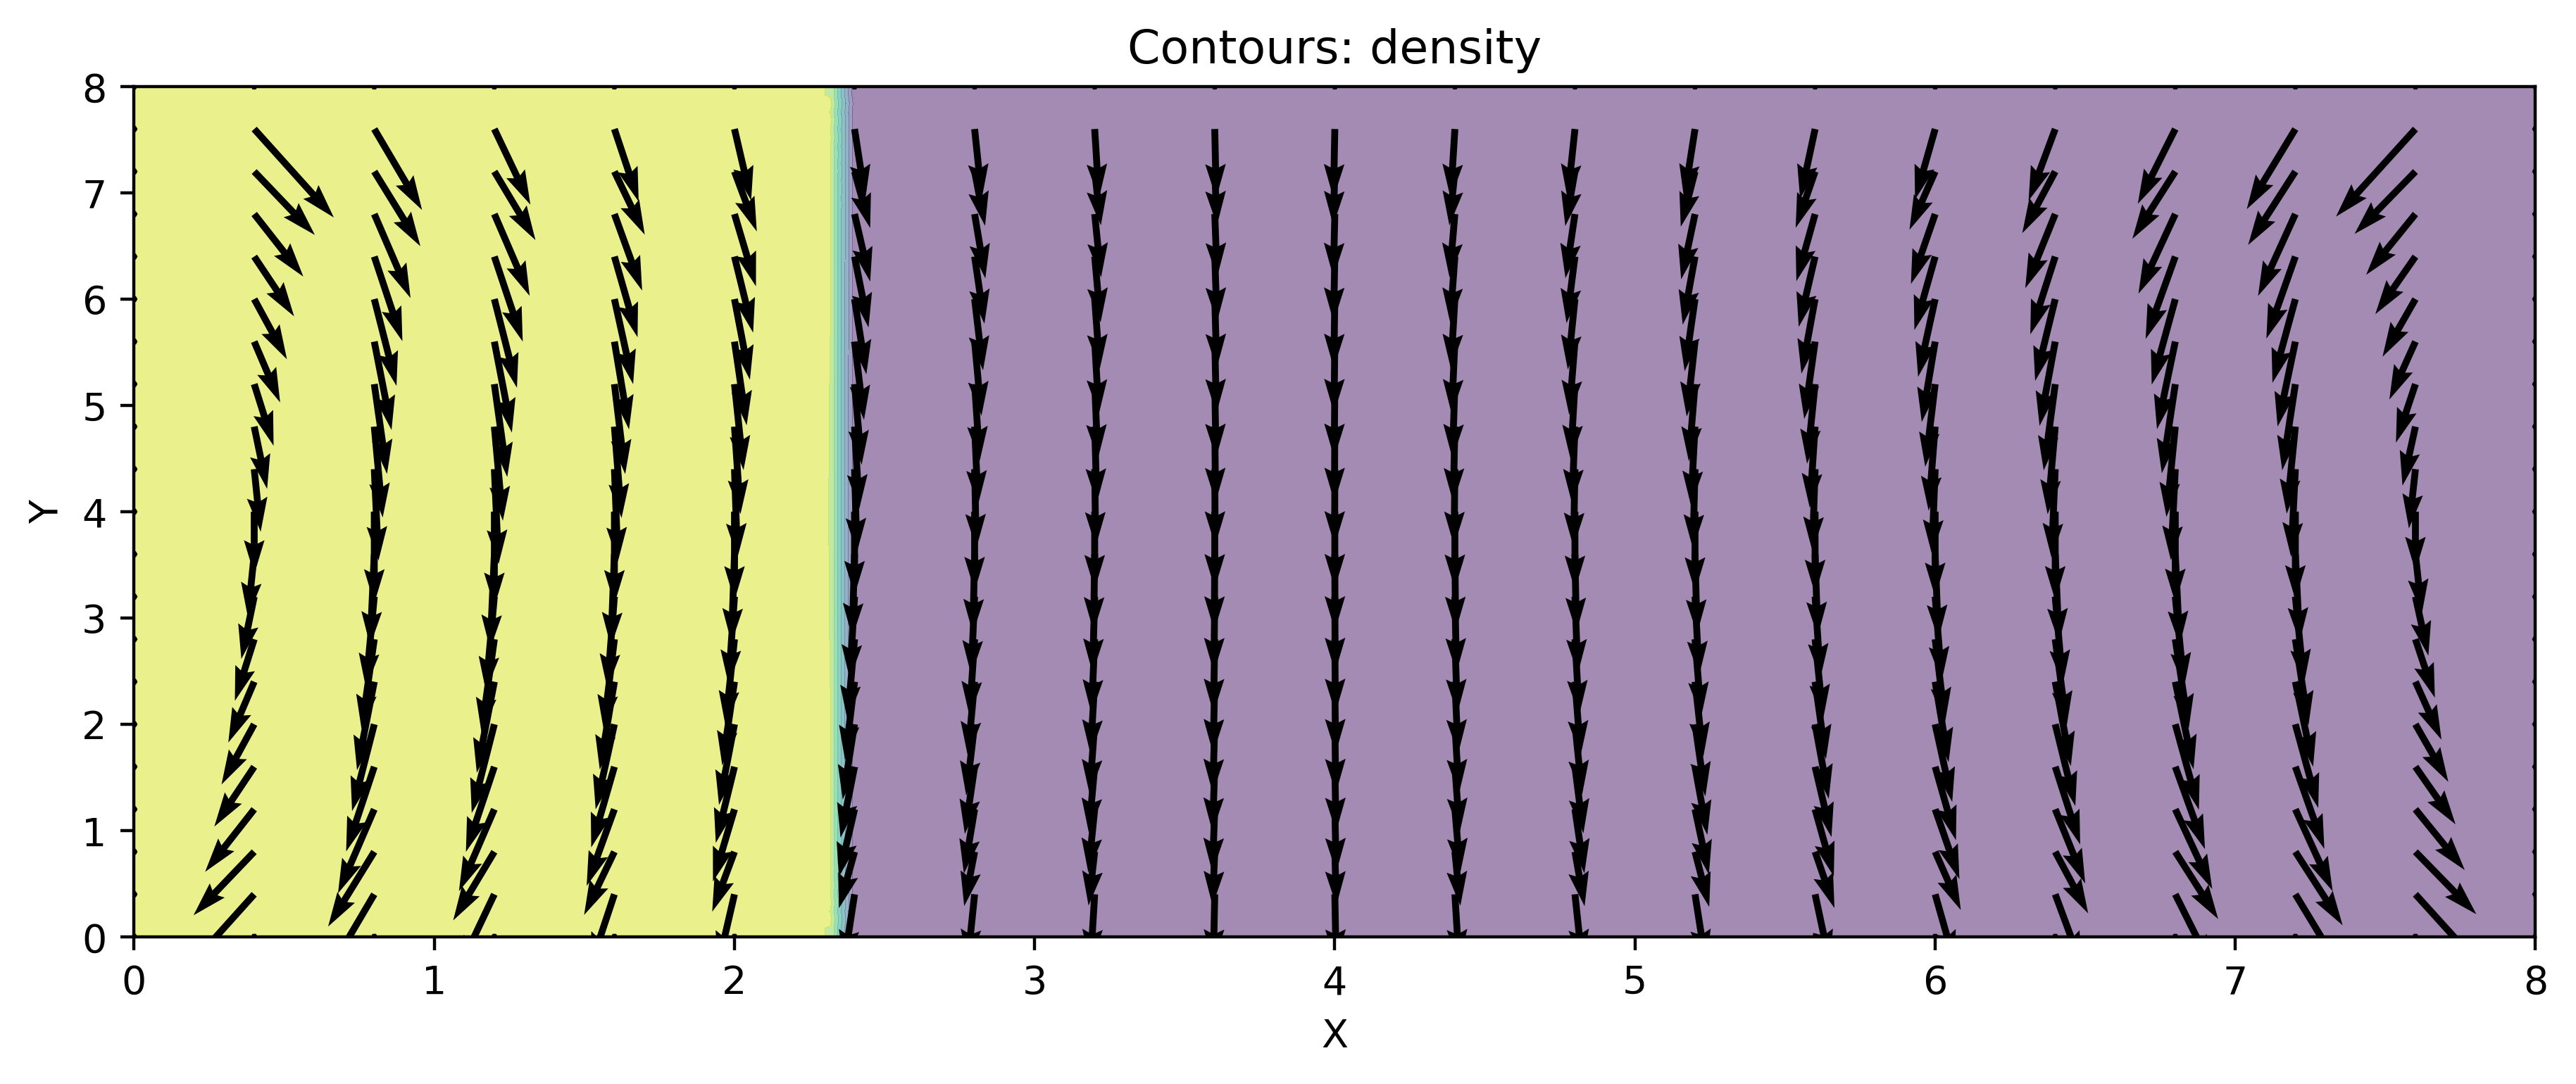

In [19]:
plt.clf() 
fig, ax1 = plt.subplots(figsize =(11,4), dpi =400 )
ax1.set_title("Contours: density")
ax1.contourf(X, Y, rho2, alpha=0.5, cmap=cm.viridis)  
im = ax1.quiver(X[::5, ::5], Y[::5, ::5], u2[::5, ::5], v2[::5, ::5])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

#im=ax2.contourf(X, Y, p2, alpha=0.5, cmap=cm.viridis)  
#ax2.quiver(X[::10, ::10], Y[::10, ::10], u2[::10, ::10], v2[::10, ::10])
#ax2.set_xlabel('X')
#ax2.set_ylabel('Y')
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
#plt.savefig('fig2.pdf', bbox_inches='tight')

Text(0,0.5,'Y')

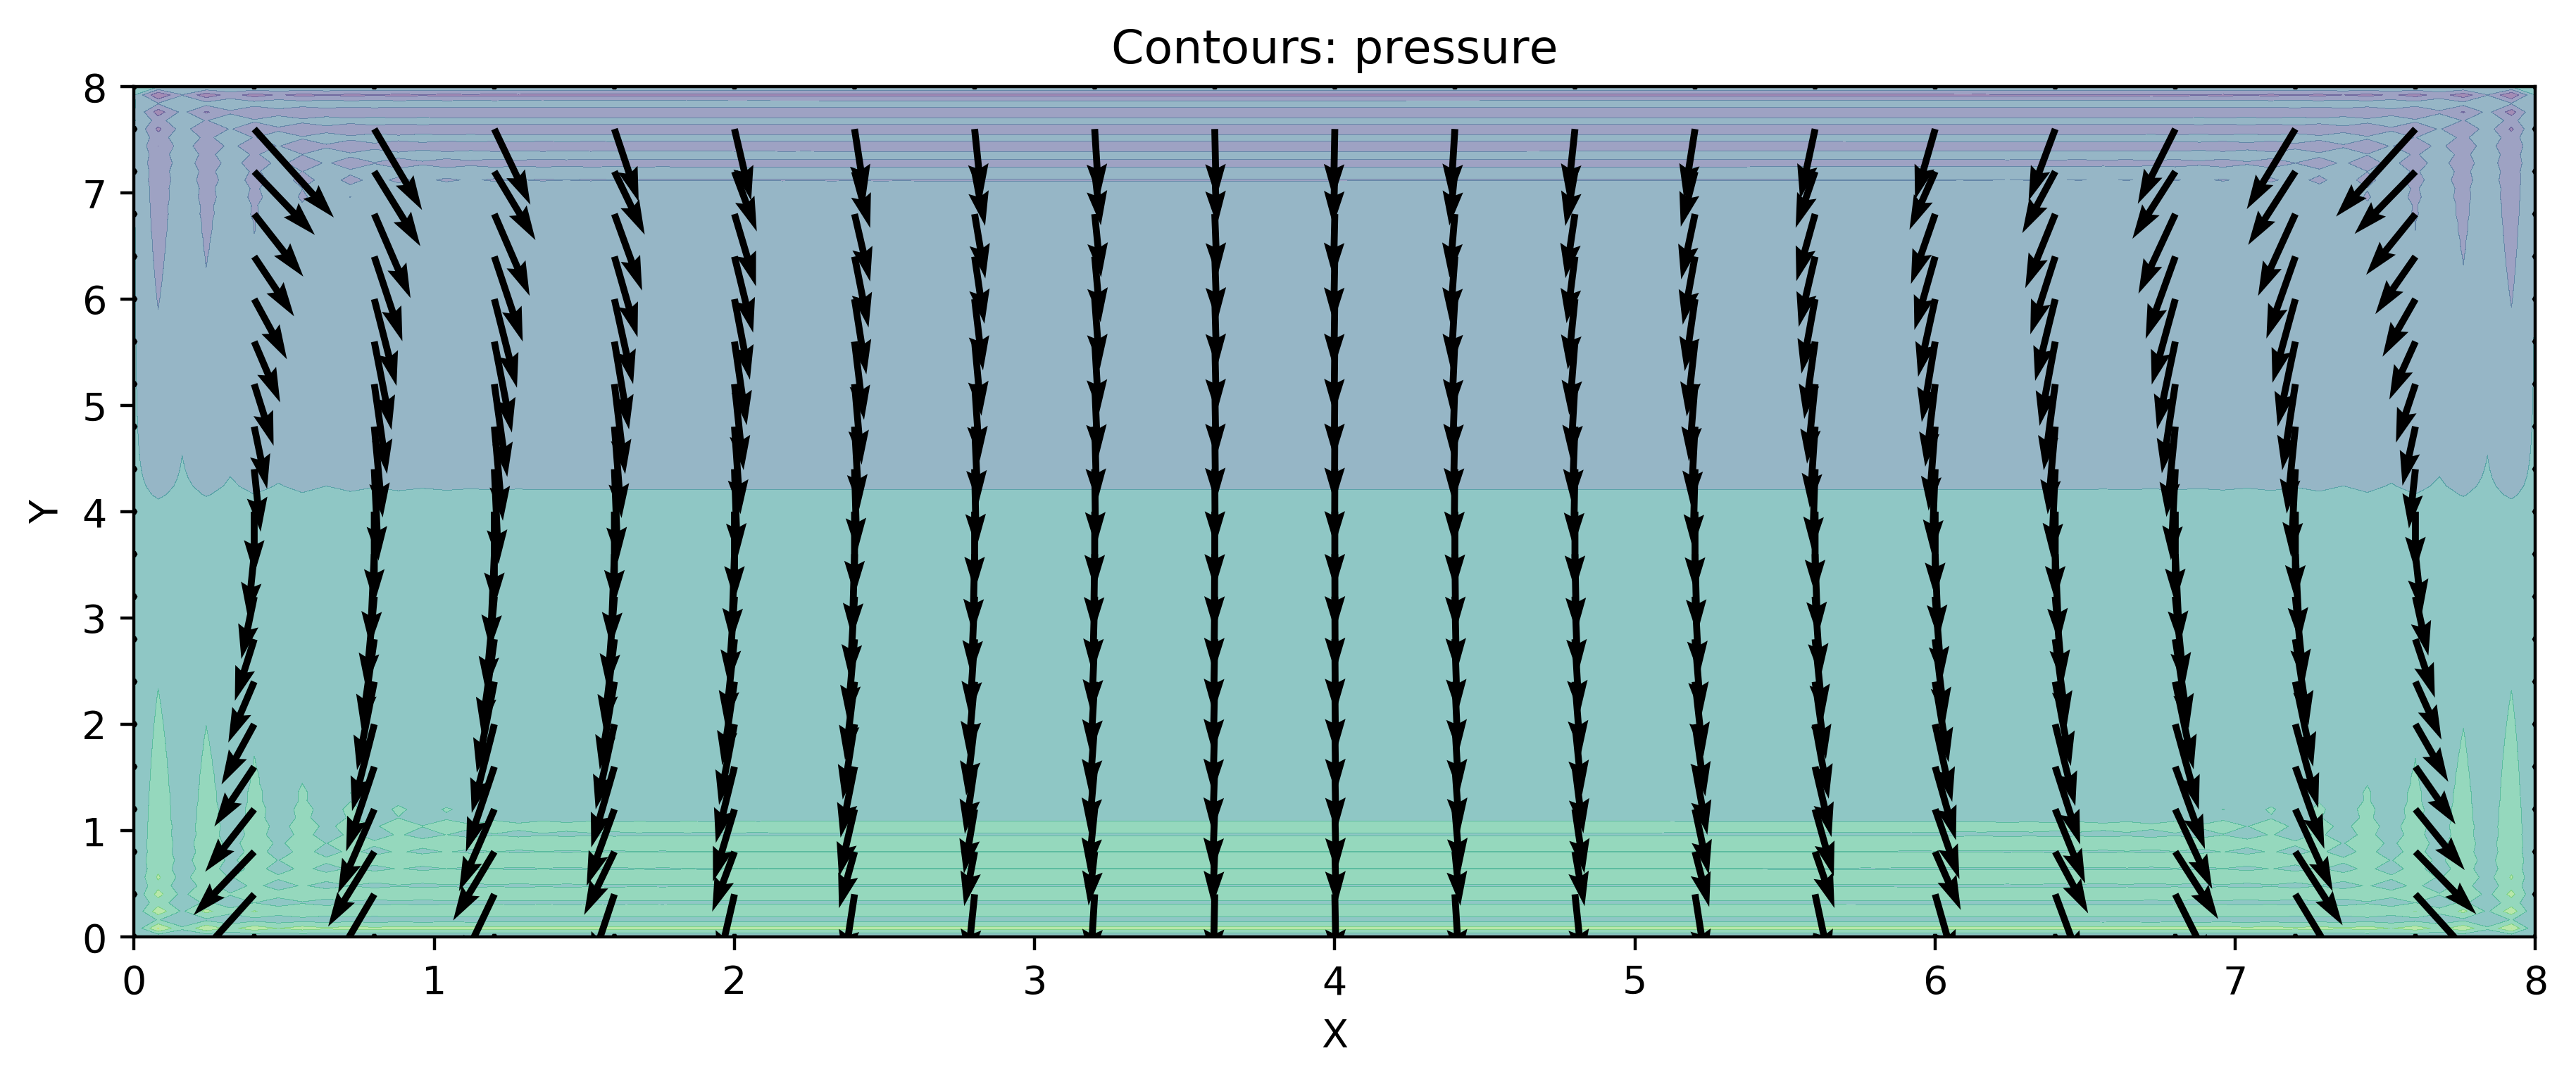

In [20]:
plt.clf() 
fig, ax1 = plt.subplots(figsize =(11,4), dpi =400 )
ax1.set_title("Contours: pressure")
ax1.contourf(X, Y, p2, alpha=0.5, cmap=cm.viridis)  
im = ax1.quiver(X[::5, ::5], Y[::5, ::5], u2[::5, ::5], v2[::5, ::5])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')